In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential

from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [2]:
TRAIN_PATH = "CovidDataset1/Train"
VAL_PATH = "CovidDataset1/Val"
TEST_PATH = "CovidDataset1/test"

In [3]:
from keras.metrics import *

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
]

In [4]:
# Train from scratch
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator(rescale = 1./255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
test_dataset = image.ImageDataGenerator(rescale=1./255)

Found 8764 images belonging to 2 classes.


In [6]:
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 2150 images belonging to 2 classes.


In [7]:
test_generator = test_dataset.flow_from_directory(
    TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 800 images belonging to 2 classes.


In [8]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping, CSVLogger
checkpoint_path = "Xception/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1,save_weights_only=True,save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('Xception/Xception.csv', separator=',', append=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5)

callbacks_list = [checkpoint, reduce_lr, log_csv]

In [9]:
def create_model():
    base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                       weights="imagenet",
                                                       input_shape=(224,224,3), 
                                                       pooling='avg') 
    for layer in base_model.layers:
      layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(55, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    

    model.compile(Adam(), loss='binary_crossentropy',metrics=METRICS)
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 55)                112695    
_________________________________________________________________
dropout (Dropout)            (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1792      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [11]:

hist = model.fit(
    train_generator,
   steps_per_epoch=len(train_generator),
    epochs = 100,
    validation_data = validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list
    
)

Epoch 1/100
274/274 [==============================] - 139s 472ms/step - loss: 0.4094 - tp: 4381.0000 - fp: 928.0000 - tn: 2753.0000 - fn: 702.0000 - accuracy: 0.8140 - precision: 0.8252 - recall: 0.8619 - val_loss: 0.2247 - val_tp: 1698.0000 - val_fp: 105.0000 - val_tn: 309.0000 - val_fn: 38.0000 - val_accuracy: 0.9335 - val_precision: 0.9418 - val_recall: 0.9781

Epoch 00001: val_loss improved from inf to 0.22467, saving model to Xception\cp-0001.ckpt
Epoch 2/100
274/274 [==============================] - 98s 357ms/step - loss: 0.3387 - tp: 4575.0000 - fp: 734.0000 - tn: 2947.0000 - fn: 508.0000 - accuracy: 0.8583 - precision: 0.8617 - recall: 0.9001 - val_loss: 0.1755 - val_tp: 1709.0000 - val_fp: 106.0000 - val_tn: 308.0000 - val_fn: 27.0000 - val_accuracy: 0.9381 - val_precision: 0.9416 - val_recall: 0.9844

Epoch 00002: val_loss improved from 0.22467 to 0.17545, saving model to Xception\cp-0002.ckpt
Epoch 3/100
274/274 [==============================] - 98s 357ms/step - loss: 0.3


Epoch 00039: val_loss did not improve from 0.15656
Epoch 40/100
274/274 [==============================] - 97s 353ms/step - loss: 0.1580 - tp: 4868.0000 - fp: 312.0000 - tn: 3369.0000 - fn: 215.0000 - accuracy: 0.9399 - precision: 0.9398 - recall: 0.9577 - val_loss: 0.1633 - val_tp: 1695.0000 - val_fp: 75.0000 - val_tn: 339.0000 - val_fn: 41.0000 - val_accuracy: 0.9460 - val_precision: 0.9576 - val_recall: 0.9764

Epoch 00040: val_loss did not improve from 0.15656
Epoch 41/100
274/274 [==============================] - 97s 352ms/step - loss: 0.1501 - tp: 4858.0000 - fp: 262.0000 - tn: 3419.0000 - fn: 225.0000 - accuracy: 0.9444 - precision: 0.9488 - recall: 0.9557 - val_loss: 0.1658 - val_tp: 1696.0000 - val_fp: 76.0000 - val_tn: 338.0000 - val_fn: 40.0000 - val_accuracy: 0.9460 - val_precision: 0.9571 - val_recall: 0.9770

Epoch 00041: val_loss did not improve from 0.15656
Epoch 42/100
274/274 [==============================] - 100s 364ms/step - loss: 0.1572 - tp: 4865.0000 - fp: 315


Epoch 00078: val_loss did not improve from 0.15656
Epoch 79/100
274/274 [==============================] - 97s 353ms/step - loss: 0.1641 - tp: 4828.0000 - fp: 330.0000 - tn: 3351.0000 - fn: 255.0000 - accuracy: 0.9332 - precision: 0.9360 - recall: 0.9498 - val_loss: 0.1646 - val_tp: 1695.0000 - val_fp: 71.0000 - val_tn: 343.0000 - val_fn: 41.0000 - val_accuracy: 0.9479 - val_precision: 0.9598 - val_recall: 0.9764

Epoch 00079: val_loss did not improve from 0.15656
Epoch 80/100
274/274 [==============================] - 97s 353ms/step - loss: 0.1506 - tp: 4850.0000 - fp: 298.0000 - tn: 3383.0000 - fn: 233.0000 - accuracy: 0.9394 - precision: 0.9421 - recall: 0.9542 - val_loss: 0.1652 - val_tp: 1696.0000 - val_fp: 71.0000 - val_tn: 343.0000 - val_fn: 40.0000 - val_accuracy: 0.9484 - val_precision: 0.9598 - val_recall: 0.9770

Epoch 00080: val_loss did not improve from 0.15656
Epoch 81/100
274/274 [==============================] - 97s 353ms/step - loss: 0.1594 - tp: 4859.0000 - fp: 303.


Epoch 00098: val_loss did not improve from 0.15656
Epoch 99/100
274/274 [==============================] - 108s 393ms/step - loss: 0.1606 - tp: 4841.0000 - fp: 315.0000 - tn: 3366.0000 - fn: 242.0000 - accuracy: 0.9364 - precision: 0.9389 - recall: 0.9524 - val_loss: 0.1641 - val_tp: 1697.0000 - val_fp: 72.0000 - val_tn: 342.0000 - val_fn: 39.0000 - val_accuracy: 0.9484 - val_precision: 0.9593 - val_recall: 0.9775

Epoch 00099: val_loss did not improve from 0.15656
Epoch 100/100
274/274 [==============================] - 104s 380ms/step - loss: 0.1535 - tp: 4868.0000 - fp: 311.0000 - tn: 3370.0000 - fn: 215.0000 - accuracy: 0.9400 - precision: 0.9399 - recall: 0.9577 - val_loss: 0.1654 - val_tp: 1696.0000 - val_fp: 71.0000 - val_tn: 343.0000 - val_fn: 40.0000 - val_accuracy: 0.9484 - val_precision: 0.9598 - val_recall: 0.9770

Epoch 00100: val_loss did not improve from 0.15656


In [12]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0016.ckpt.index',
 'cp-0017.ckpt.data-00000-of-00001',
 'cp-0017.ckpt.index',
 'cp-0018.ckpt.data-00000-of-00001',
 'cp-0018.ckpt.index',
 'cp-0019.ckpt.data-00000-of-00001',
 'cp-0019.ckpt.index',
 'cp-0020.ckpt.data-00000

In [13]:
import tensorflow
latest = tensorflow.train.latest_checkpoint(checkpoint_dir)
latest


'Xception\\cp-0007.ckpt'

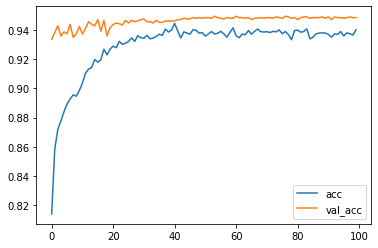

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig('val')

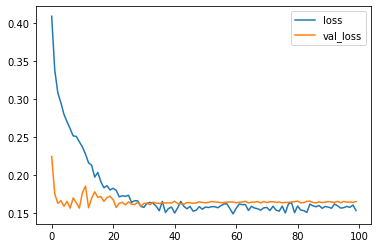

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig('val')

In [20]:
# Create a basic model instance
model = create_model()

# Evaluate the model
results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The model has a 94.77543830871582% accuracy, with a loss of 0.5879948139190674.


In [21]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)
results=[]

results = model.evaluate_generator(validation_generator,1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 
print("tp {} , fp {}.".format(results[1], results[2])) 
print("tn {} , fn {}.".format(results[3], results[4]))
print("precission {} , recall {}.".format(results[6], results[7])) 


The model has a 94.76061463356018% accuracy, with a loss of 0.2238464504480362.
tp 1749.0 , fp 76.0.
tn 349.0 , fn 40.0.
precission 0.9583561420440674 , recall 0.9776411652565002.


In [22]:
model.evaluate_generator(train_generator)

[0.22409400343894958,
 4862.0,
 578.0,
 3103.0,
 221.0,
 0.9088315963745117,
 0.893750011920929,
 0.95652174949646]

In [23]:
model.evaluate_generator(validation_generator)

[0.15655572712421417,
 1713.0,
 98.0,
 316.0,
 23.0,
 0.9437209367752075,
 0.9458862543106079,
 0.986751139163971]

In [24]:
model.evaluate_generator(test_generator)

[0.2994662821292877,
 387.0,
 89.0,
 311.0,
 13.0,
 0.8725000023841858,
 0.8130252361297607,
 0.9674999713897705]

In [25]:
import os
train_generator.class_indices

{'Covid': 0, 'Negative': 1}

In [26]:
y_actual = []
y_test = []

In [27]:
for i in os.listdir("CovidDataset/Val/Negative/"):
   img = image.load_img("CovidDataset/Val/Negative/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   a=np.round(p[0,0])
   y_test.append(a)
   y_actual.append(1)

In [ ]:
for i in os.listdir("CovidDataset/Val/Covid/"):
   img = image.load_img("CovidDataset/Val/Covid/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   a=np.round(p[0,0])
   y_test.append(a)
   y_actual.append(0)

In [ ]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [ ]:
predicted=model.predict(validation_generator,batch_size=10)
reonded_predicted= np.round(predicted)
reonded_predicted

In [ ]:
print(y_actual)

In [ ]:
print(y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual,(np.round(y_test)))
cm

In [ ]:
cm=[[318, 97],
     [ 23, 1713]]

import seaborn as sns

ax = sns.heatmap(cm/np.sum(cm), cmap = "Blues", fmt='.2%', annot=True)

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
cm=[[318, 97],
     [ 23, 1713]]

import seaborn as sns

ax = sns.heatmap(cm, cmap = "Blues", annot=True, fmt=".0f")

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()